In [1]:
!pip install -q -U watermark

In [2]:
# INSTALLING PYTORCH TRANSFORMERS LIBRARY BY HUGGING FACE FOR PERFOMING BERT 

!pip install -qq transformers

     |████████████████████████████████| 1.8MB 21.0MB/s 
     |████████████████████████████████| 3.2MB 50.9MB/s 
     |████████████████████████████████| 890kB 53.9MB/s 


In [3]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

CPython 3.6.9
IPython 5.5.0

numpy 1.19.5
pandas 1.1.5
torch 1.7.0+cu101
transformers 4.3.2


In [4]:
# IMPORTING THE NECESSARY LIBRARIES THAT WILL BE USED FOR PERFORMING TEXT CLASSIFICATION

import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
import joblib
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [5]:
# NUMBER 1: DATA EXPLORATION AND PREPROCESSING

from google.colab import files
upload=files.upload() # LOADING DATA FROM OUR LOCAL MACHINE

Saving dataset.csv to dataset.csv


In [6]:
# READING THE DATASET AND DISPLAYING ITS CONTENTS
data=pd.read_csv('dataset.csv', header=0)
data.head()

,text,TextLabel,label
0,.omg why are poc wearing fugly blue contacts s...,Non-Bullying,0
1,.Sorry but most of the runners popular right n...,Non-Bullying,0
2,Was there always this much hatred and prejudic...,Non-Bullying,0
3,"The fray, seattle, pride and prejudice, books,...",Non-Bullying,0
4,We must not stand for prejudice and discrimina...,Non-Bullying,0


In [7]:
data.shape # DATASET SHAPE (No. OF ROWS AND COLUMNS)

(915, 3)

In [8]:
data.info() # DATASET INFORMATION (DATA TYPE AND NULL COUNT)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 915 entries, 0 to 914
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       915 non-null    object
 1   TextLabel  915 non-null    object
 2   label      915 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 21.6+ KB


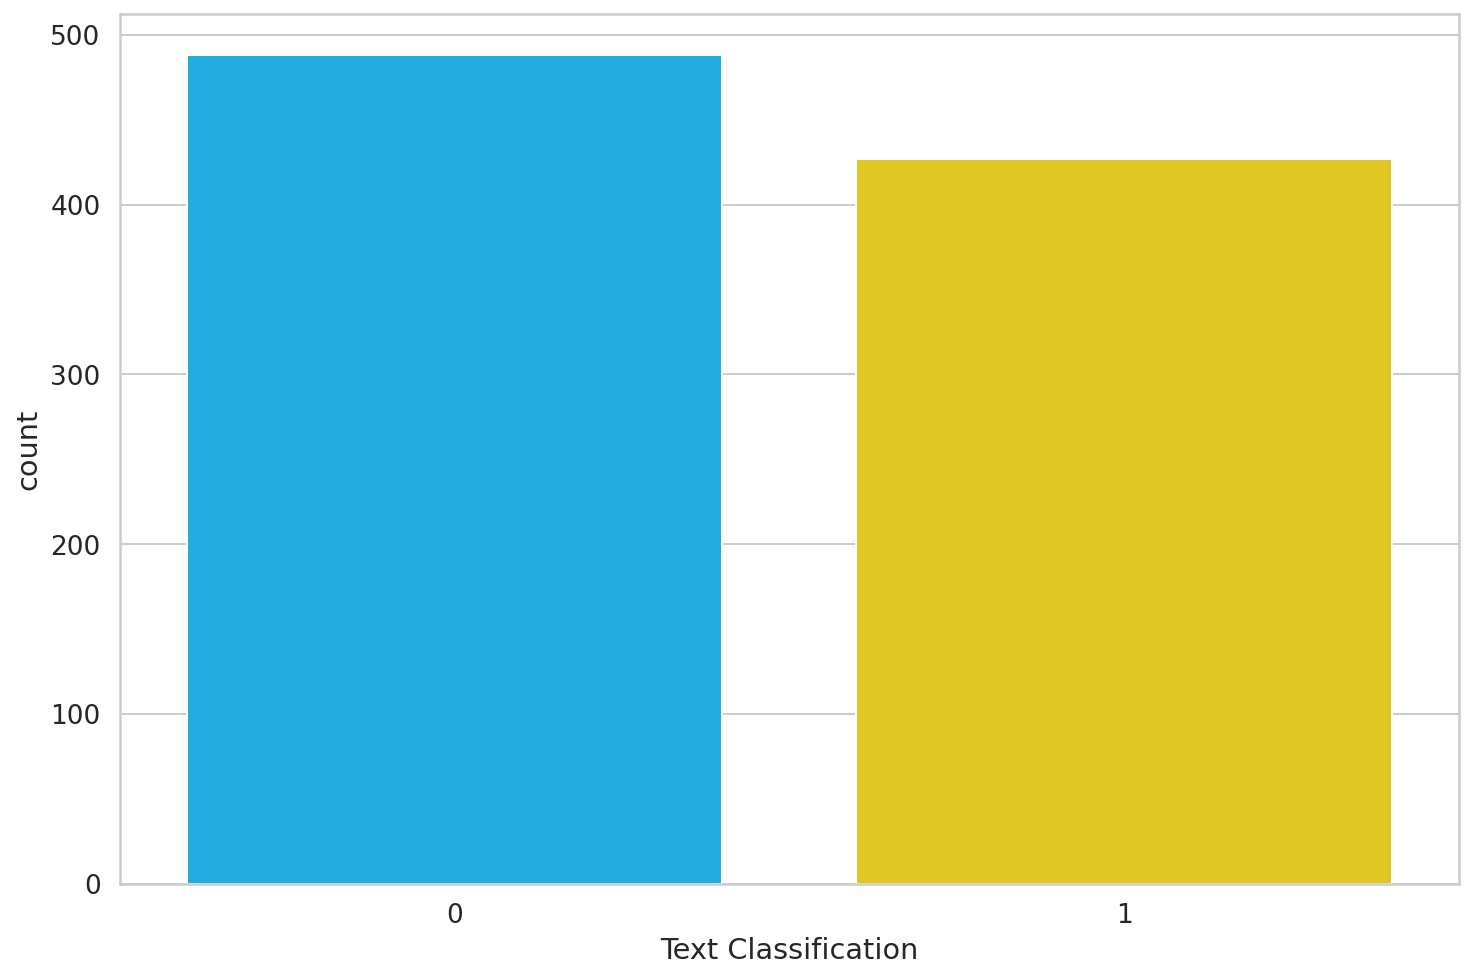

In [9]:
sns.countplot(data.label)
plt.xlabel('Text Classification');

In [10]:
# INITIALIZING THE SENTIMENTS
def to_sentiment(label):
  label = int(label)
  if label == 1:
    return 1
  else:
    return 0
data['sentiment'] = data.label.apply(to_sentiment)

In [11]:
class_names = ['Non-Bullying', 'Bullying']

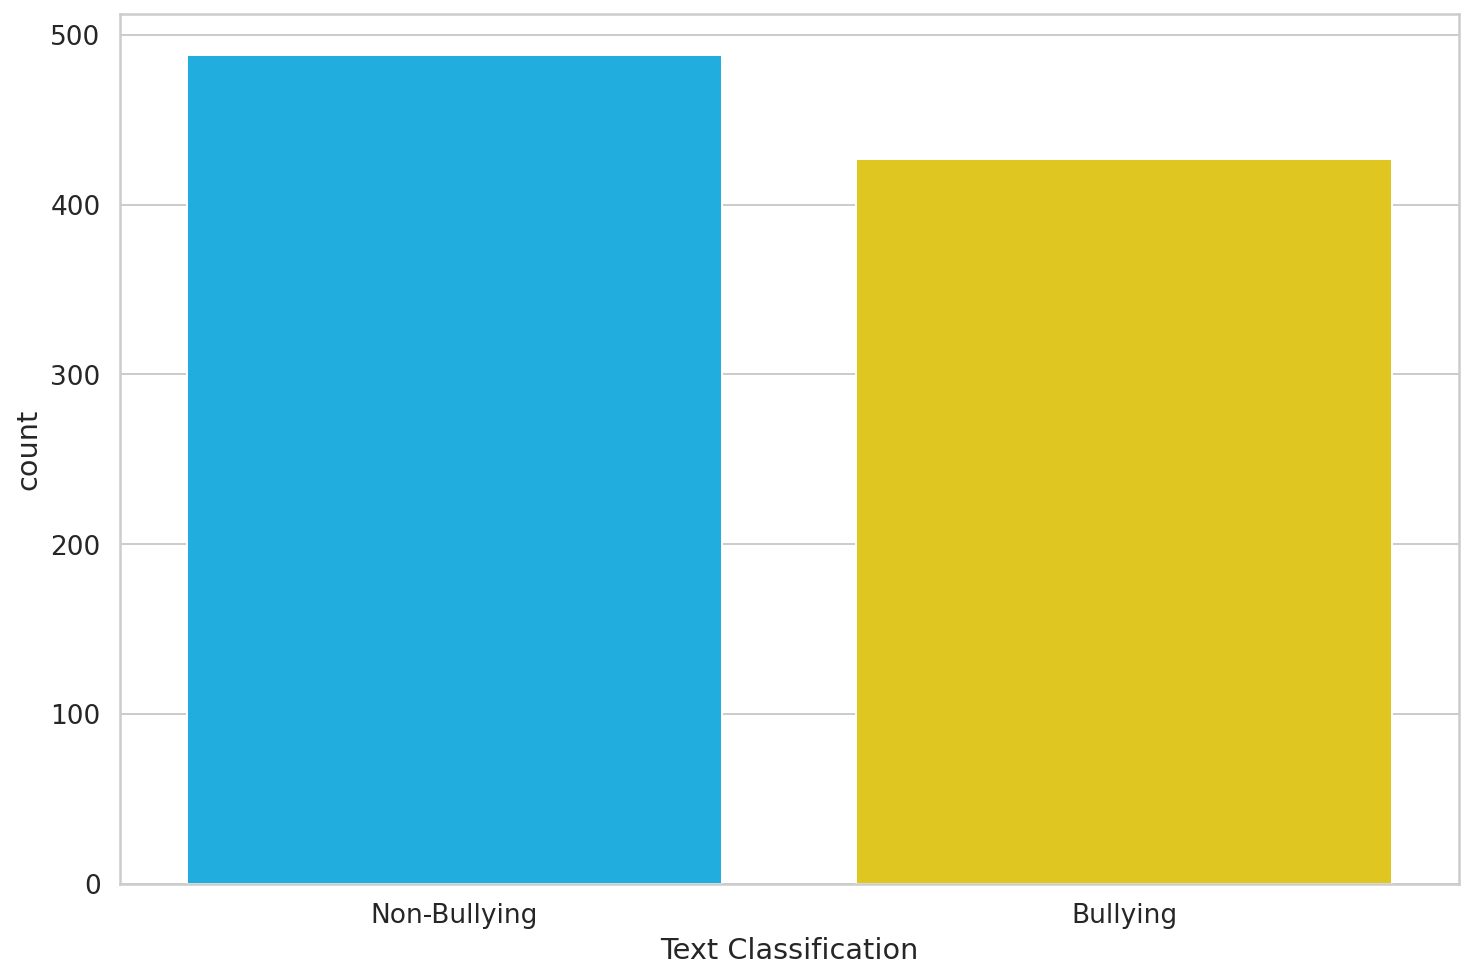

In [12]:
# PLOTTING THE DISTRIBUTION OF SENTIMENTS 
ax = sns.countplot(data.sentiment)
plt.xlabel('Text Classification')
ax.set_xticklabels(class_names);
#from google.colab import files
#plt.savefig('Sentiment_Score.pdf')    # SAVING THE PLOTTED GRAPH
#files.download('Sentiment_Score.pdf') # DOWNLOADING THE PLOTTED GRAPH

In [13]:
# NUMBER 2: DATA PREPROCESSING
# WE'LL USE THE CASED VERSION SINCE IT PERFORMS BETTER THAN UNCASED
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'  

In [14]:
# LOADING PRE-TRAINED BERT TOKENIZER
# from transformers import AutoModel, AutoTokenizer
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)  #LOADING OUR TOKENIZER

In [15]:
# CREATING A SAMPLE TEXT IN ORDER TO UNDERSTAND THE TOKENIZATION PROCESS
sample_txt = 'Hey! dont talk like that. You are ugly.'

In [16]:
# CONVERTING THE TEXT WE'VE CREATED ABOVE TO TOKENS THEN CONVERTING THE TOKEN TO UNIQUE INTEGER IDS
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print(f' Sentence: {sample_txt}') # PRINTING THE SENTENCE
print(f'   Tokens: {tokens}')     # PRINTING THE TOKENS CREATED
print(f'Token IDs: {token_ids}')  # PRINTING THE IDS CREATED

 Sentence: Hey! dont talk like that. You are ugly.
   Tokens: ['Hey', '!', 'don', '##t', 'talk', 'like', 'that', '.', 'You', 'are', 'ugly', '.']
Token IDs: [4403, 106, 1274, 1204, 2037, 1176, 1115, 119, 1192, 1132, 10126, 119]


In [17]:
# SPECIAL TOKENS
# [SEP]- MARKER FOR ENDING OF A SENTENCE
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 102)

In [18]:
# [CLS]- THIS TOKEN SHOULD BE ADDED BEFORE EVERY SENTENCE IN ORDER FOR BERT TO KNOW WE ARE DOING CLASSIFICATION
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 101)

In [19]:
# [PAD]- SPECIAL TOKEN USED FOR PADDING
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

In [20]:
# [UNK]- UNKNOWN TOKEN. BERT UNDERSTANDS EVERYTHING THAT WAS IN THE TRAINING SET EVERY OTHER DATA CAN BE ENCODED WITH THE UNK TOKEN
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 100)

In [21]:
# USING ENCODE_PLUS() METHOD
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True,       # ADDS '[CLS]' and '[SEP]' TO THE SENTENCES
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',           # RETURNING PYTORCH SENSORS
)
encoding.keys()

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


dict_keys(['input_ids', 'attention_mask'])

In [22]:
# THE TOKENS ARE STORED IN A TENSOR 
print(len(encoding['input_ids'][0])) # PRINTING THE TOKENNS CONTAINED IN THE TENSOR AND THE PADDING LENGTH
encoding['input_ids'][0]

32


tensor([  101,  4403,   106,  1274,  1204,  2037,  1176,  1115,   119,  1192,
         1132, 10126,   119,   102,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0])

In [23]:
# DISPLAYING THE ATTENTION MASK TOKENS 
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

32


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

In [24]:
# INVERSING OUR TOKENS SO AS TO HAVE A LOOK AT THE SPECIAL TOKENS WE CREATED
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'Hey',
 '!',
 'don',
 '##t',
 'talk',
 'like',
 'that',
 '.',
 'You',
 'are',
 'ugly',
 '.',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

In [25]:
token_lens = []
for txt in data.text:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

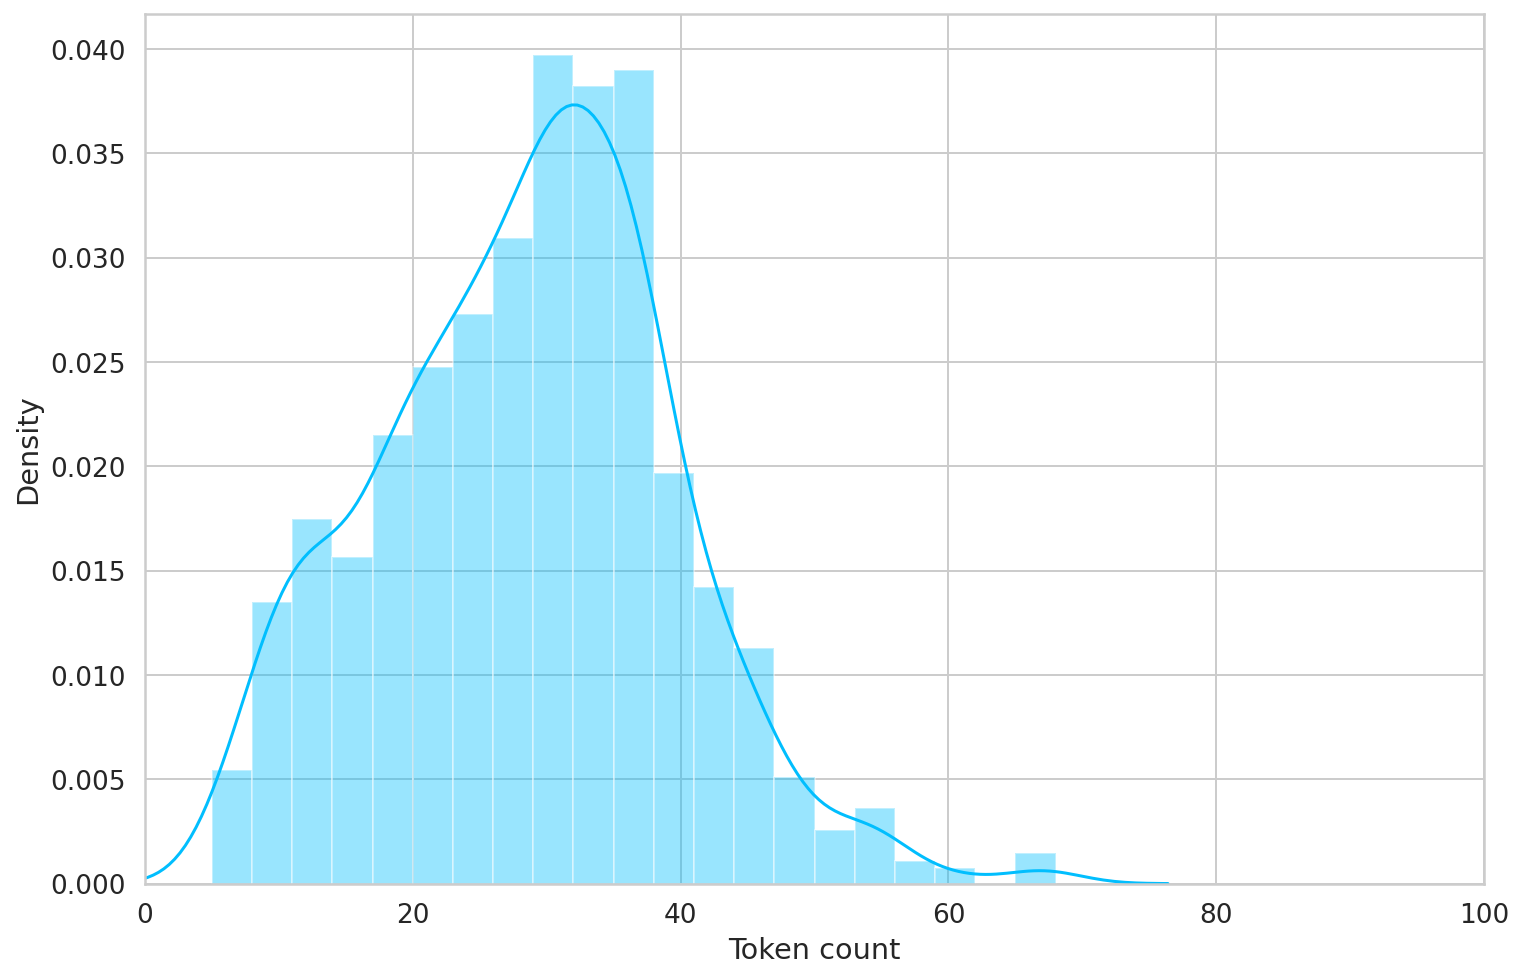

In [26]:
# NUMBER 3: CHOOSING THE SEQUENCE LENGTH
# PLOTTING THE DISTRTIBUTION OF OUR TOKEN LENGTH
sns.distplot(token_lens)
plt.xlim([0, 100]);
plt.xlabel('Token count');
from google.colab import files
plt.savefig('Token.pdf')     # SAVING THE PLOTTED GRAPH
files.download('Token.pdf')  # DOWNLOADING THE PLOTTED GRAPH

In [27]:
MAX_LEN = 120

In [28]:
# CREATING OUR PYTORCH DATASET SINCE WE HAVE EVERYTHING WE REQUIRE
class GPSentimentDataset(Dataset):
  def __init__(self, Tweets, targets, tokenizer, max_len):
    self.Tweets = Tweets
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
    
  def __len__(self):
    return len(self.Tweets)
  
  def __getitem__(self, item):
    Tweet = str(self.Tweets[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      Tweet,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )
    return {
      'Tweet_text': Tweet,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [29]:
# EVALUATING THE PREDICTIONS FROM OUR MODEL
data_train, data_test = train_test_split(data, test_size=0.4, random_state=RANDOM_SEED)     # TRAIN DATASET
data_val, data_test = train_test_split(data_test, test_size=0.6, random_state=RANDOM_SEED)  # VALIDATION DATASET

In [30]:
data_train.shape, data_val.shape, data_test.shape

((549, 4), (146, 4), (220, 4))

In [31]:
# CREATING DATA LOADERS FOR THE BERT MODEL
def create_data_loader(data, tokenizer, max_len, batch_size):
  ds = GPSentimentDataset(
    Tweets=data.text.to_numpy(),
    targets=data.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )
  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [32]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(data_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(data_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(data_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [33]:
# EXAMPLE OF OUR BATCH FROM THE TRAIN DATA LOADER,
data = next(iter(train_data_loader))
data.keys()

dict_keys(['Tweet_text', 'input_ids', 'attention_mask', 'targets'])

In [34]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 120])
torch.Size([16, 120])
torch.Size([16])


In [35]:
# SENTIMENT CLASSIFICATION USING THE BERT MODEL
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=False)

In [36]:
# WE ARE USING THE BERT MODEL WE'VE LOADED ABOVE TO ENCODE THE SAMPLE TEXT WE CREATED ABOVE
last_hidden_state, pooled_output = bert_model(
  input_ids=encoding['input_ids'], 
  attention_mask=encoding['attention_mask']
)

In [37]:
last_hidden_state.shape

torch.Size([1, 32, 768])

In [38]:
pooled_output.shape

torch.Size([1, 768])

In [39]:
# WE'RE CREATING A CLASSIFIER THAT USES THE BERT MODEL
class SentimentClassifier(nn.Module):
  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=False)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [40]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

In [41]:
# MOVING THE EXAMPLE BATCH OF OUR TRAINING DATA TO THE GPU
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 120])
torch.Size([16, 120])


In [42]:
# APPLYING SOFTMAX FUNCTION TO THE OUTPUT IN ORDER TO GET THE PREDICTED PROBABILITIES OF OUR TRAINED MODEL
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.7013, 0.2987],
        [0.7911, 0.2089],
        [0.6628, 0.3372],
        [0.8447, 0.1553],
        [0.7906, 0.2094],
        [0.6696, 0.3304],
        [0.7587, 0.2413],
        [0.4919, 0.5081],
        [0.6933, 0.3067],
        [0.5091, 0.4909],
        [0.7203, 0.2797],
        [0.6101, 0.3899],
        [0.8483, 0.1517],
        [0.7716, 0.2284],
        [0.6472, 0.3528],
        [0.6578, 0.3422]], device='cuda:0', grad_fn=<SoftmaxBackward>)

In [44]:
# SETTING UP OUT OPTIMIZER AND SCHEDULER 
EPOCHS =10
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)  # WE'RE USING THE ADAMW OPTIMIZER PROVIDED BY HUGGING FACE
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(                        # WE'RE USING THE LINEAR SCHEDULER 
  optimizer,
  num_warmup_steps=0,                                               # WE'RE USING THE LINEAR SCHEDULER WITH NO WARM UP STEPS
  num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

In [45]:
# HELPER FUNCTION FOR TRAINING OUR MODEL FOR ONE EPOCH
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()
  losses = []
  correct_predictions = 0

  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)
    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)
    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [46]:
# HELPER FUNCTION THAT HELPS US EVALUATE THE MODEL ON A GIVEN DATA LOADER
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [47]:
# CREATING OUR TRAINING LOOP AND STORING THE TRAINING HISTORY
%%time
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)
  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(data_train)
  )
  print(f'Train loss {train_loss} accuracy {train_acc}')
  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(data_val)
  )
  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()
  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)
  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/10
----------
Train loss 0.6125165356057031 accuracy 0.6794171220400729
Val   loss 0.5181419685482979 accuracy 0.732876712328767

Epoch 2/10
----------
Train loss 0.3925557942262718 accuracy 0.848816029143898
Val   loss 0.6054827876389026 accuracy 0.7602739726027397

Epoch 3/10
----------
Train loss 0.22104400470852853 accuracy 0.9326047358834244
Val   loss 0.6939193512313068 accuracy 0.773972602739726

Epoch 4/10
----------
Train loss 0.0984860906643527 accuracy 0.9781420765027322
Val   loss 0.9488006010651588 accuracy 0.7945205479452054

Epoch 5/10
----------
Train loss 0.08617081941504563 accuracy 0.97632058287796
Val   loss 1.17670384865487 accuracy 0.7945205479452054

Epoch 6/10
----------
Train loss 0.04851254941562989 accuracy 0.9854280510018215
Val   loss 1.6862334765028208 accuracy 0.7123287671232876

Epoch 7/10
----------
Train loss 0.07006394563941284 accuracy 0.9854280510018215
Val   loss 1.0842154577549081 accuracy 0.7876712328767123

Epoch 8/10
----------
Train lo

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

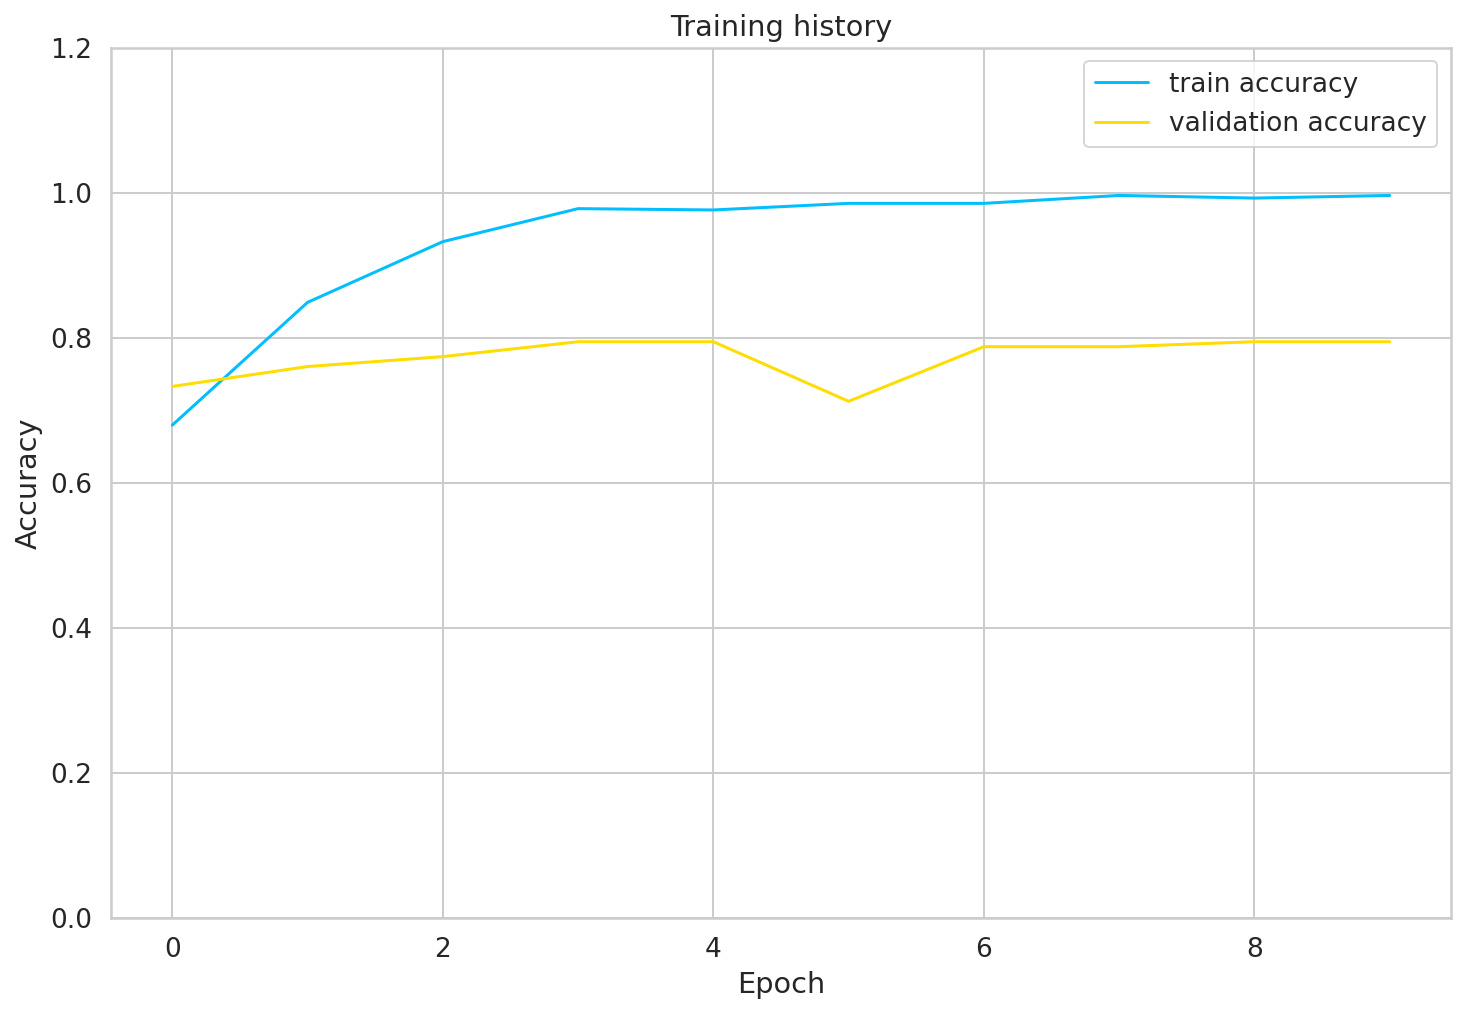

In [48]:
# PLOTTING OUR TRAINING VS VALIDATION ACCURACY
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1.2]);
from google.colab import files
plt.savefig('Training_Graph.pdf')    # SAVING THE LOTTED GRAPH
files.download('Training_Graph.pdf') # DOWNLOADING THE PLOTTED GRAPH

In [49]:
# EVALUATING THE ACCURACY OF OUR TEST DATA
test_acc, _ = eval_model(   # EVALUATING THE ACCURACY OF OUR TEST DATA
  model,
  test_data_loader,
  loss_fn,
  device,
  len(data_test)
)
test_acc.item()

0.7954545454545454

In [50]:
# HELPER FUNCTION TO GET PREDICTIONS FROM OUR MODEL
def get_predictions(model, data_loader):
  model = model.eval()
  
  Tweet_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:
      texts = d["Tweet_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      probs = F.softmax(outputs, dim=1)
      Tweet_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return Tweet_texts, predictions, prediction_probs, real_values

In [51]:
y_Tweet_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [52]:
# PRINTING THE CLASSIFICATION REPORT
print(classification_report(y_test, y_pred, target_names=class_names))


              precision    recall  f1-score   support

Non-Bullying       0.83      0.77      0.80       117
    Bullying       0.76      0.83      0.79       103

    accuracy                           0.80       220
   macro avg       0.80      0.80      0.80       220
weighted avg       0.80      0.80      0.80       220



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

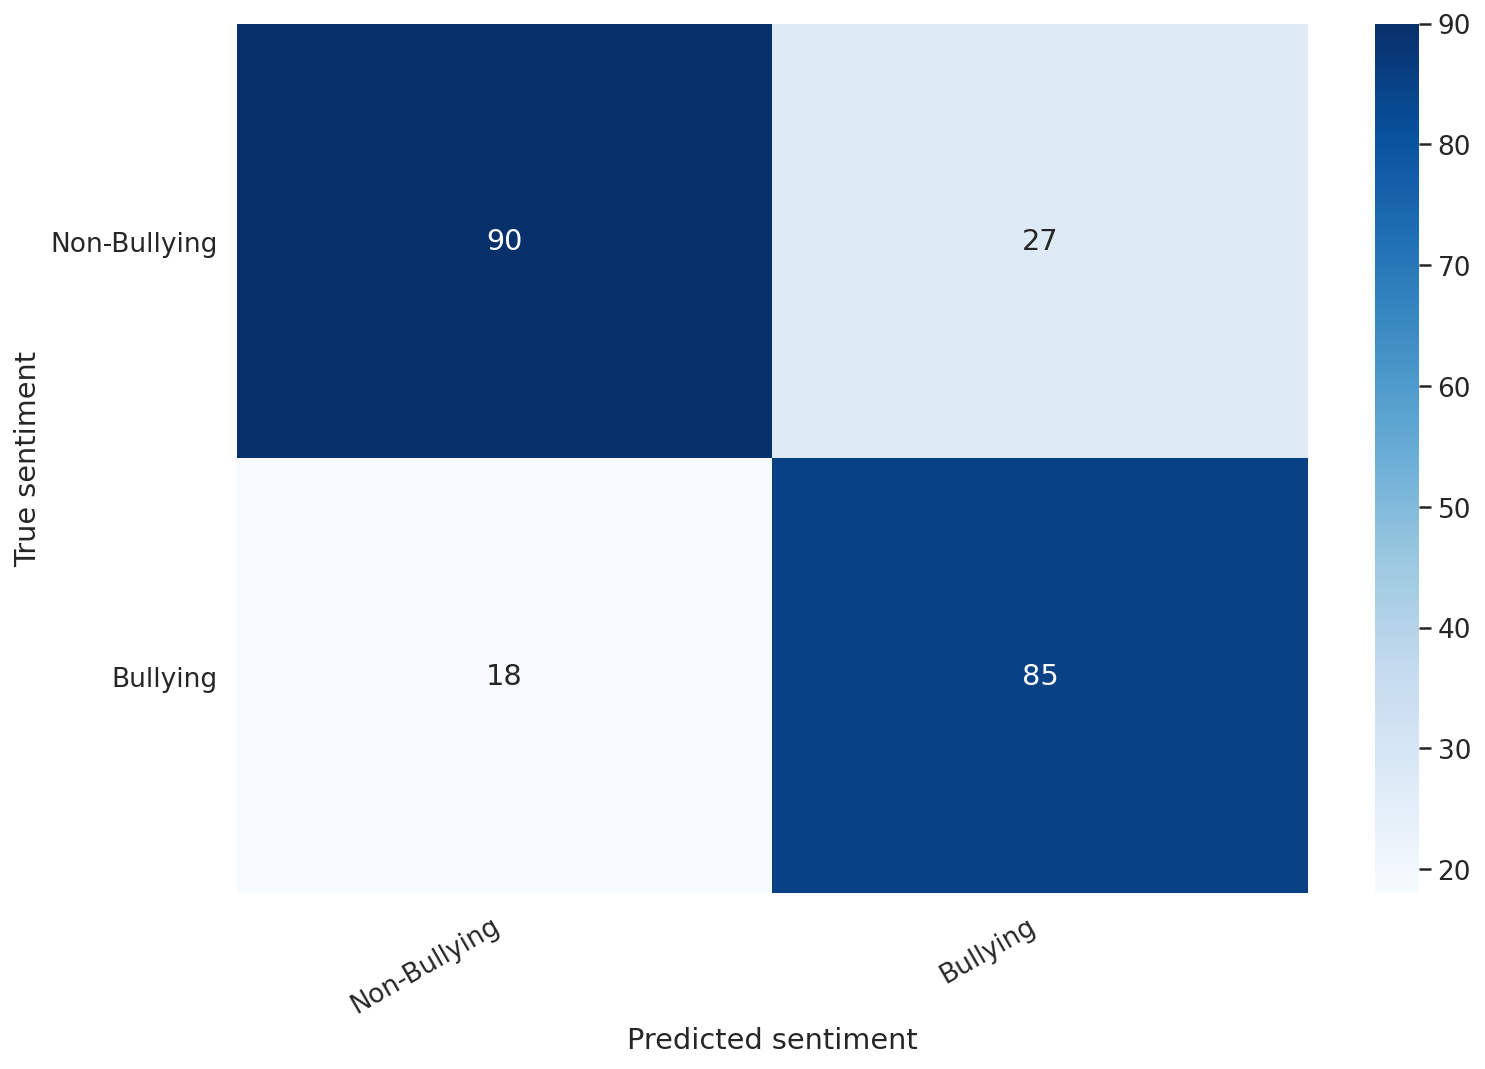

In [53]:
# PLOTTING OUR CONFUSION MATRIX
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
data_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(data_cm)
from google.colab import files
plt.savefig('Confusion_Matrix.pdf')      # SAVING THE PLOTTED GRAPH
files.download('Confusion_Matrix.pdf')   # DOWNLOADING THE PLOTTED GRAPH

In [54]:
# EVALUATING OUR TEST DATA
idx = 2
Tweet_text = y_Tweet_texts[idx]
true_sentiment = y_test[idx]
pred_data = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

In [55]:
# PRINTING THE TEST DATA
print("\n".join(wrap(Tweet_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')

Travel is fatal to prejudice, bigotry, and narrow-mindedness, and many
of our people need it sorely on these accounts.', 'Broad,.

True sentiment: Non-Bullying


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

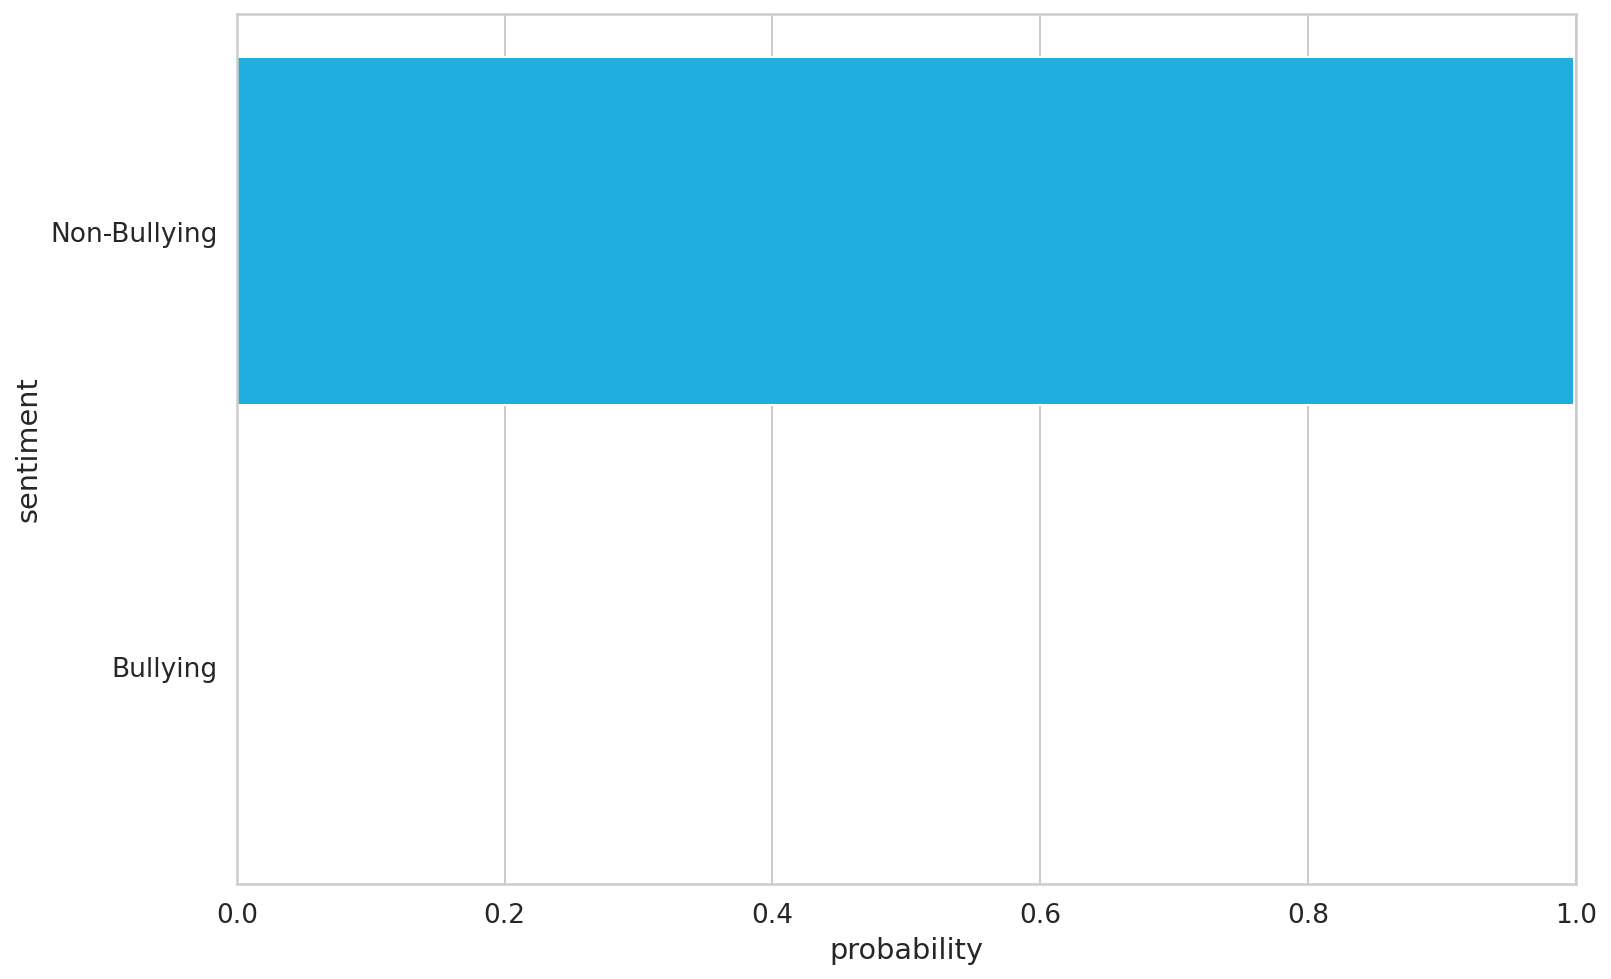

In [56]:
# PLOTTING THE SENTIMENT FROM AN EXAMPLE OF OUR TEST DATA
sns.barplot(x='values', y='class_names', data=pred_data, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);
from google.colab import files
plt.savefig('Confidence.pdf')
files.download('Confidence.pdf')

In [57]:
# PREDICTING THE SENTIMENT OF RAW TEXT
Tweet_text = "You are ugly"

In [58]:
# USING THE TOKENIZER TO ENCODE THE RAW TEXT
encoded_Tweet = tokenizer.encode_plus(
  Tweet_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  padding=True,
  return_attention_mask=True,
  return_tensors='pt',
)

In [59]:
# GETTING PREDICTIONS OF THE RAW TEXT FROM OUR MODEL
input_ids = encoded_Tweet['input_ids'].to(device)
attention_mask = encoded_Tweet['attention_mask'].to(device)
output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)
print(f'Tweet text: {Tweet_text}')
print(f'Sentiment  : {class_names[prediction]}')

Tweet text: You are ugly
Sentiment  : Bullying
